In [ ]:
import pandas as pd
import os
import imagehash
from PIL import Image
import swifter 
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
import torch
from torchvision import transforms
import torchvision.models as models

df = pd.read_parquet("../data/cleaned_train_part_0001.snappy.parquet", engine="pyarrow")

In [ ]:
def hash_similarity(hash_str1, hash_str2):
    """"""
    if pd.isna(hash_str1) or pd.isna(hash_str2):
        return 0.0  # если хеша нет, то процент совподаемости ноль
    
    try:
        hash1 = imagehash.hex_to_hash(hash_str1)
        hash2 = imagehash.hex_to_hash(hash_str2)
        
        # Normalized Hamming distance (0=identical, 1=completely different)
        distance = (hash1 - hash2) / len(hash1.hash) ** 2
        return distance
    except:
        return 0.0  

df["basic_image_similarity"] = df.swifter.apply( # используем свифтер чтобы паралелизовать + дает прогресс бар
    lambda row: hash_similarity(row["base_title_image"], row["cand_title_image"]),
    axis=1
)

Pandas Apply:   0%|          | 0/500000 [00:00<?, ?it/s]

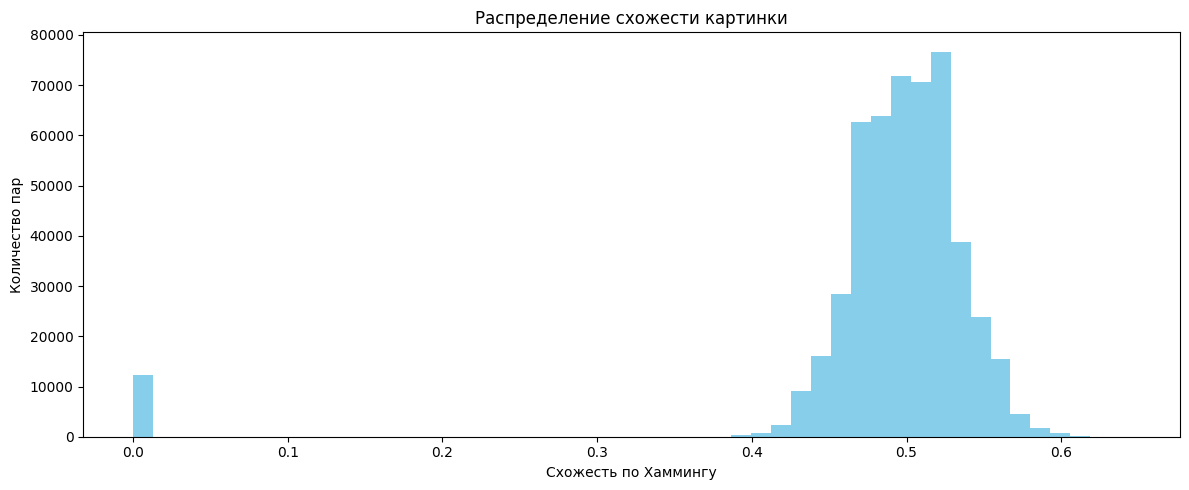

In [ ]:
from matplotlib import pyplot as plt


plt.figure(figsize=(12, 5))
plt.hist(df['basic_image_similarity'], bins=50, color='skyblue')
plt.title('Распределение схожести картинки')
plt.xlabel('Схожесть по Хаммингу')
plt.ylabel('Количество пар')
plt.tight_layout()
plt.show()

In [ ]:
# ведем учет так, чтобы аутпут не заполонялся ошибками
load_errors = []
process_errors = []
missing_files = []

"""Модель предложенная дипсиком, потому что ResNet18 достаточно мощная, не сильно требовательная"""
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model = model.eval().to(device)
preprocess = transforms.Compose([ # препроц для использования ResNet18
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def safe_image_read(img_path):
    try:
        img = Image.open(img_path).convert("RGB")
        return cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    except Exception as e:
        load_errors.append((img_path, str(e))) #сохраняем в список
        return None

def extract_features(img_path):
    try:
        img = Image.open(img_path).convert("RGB")
        img_t = preprocess(img).unsqueeze(0).to(device) #используя препроц выше
        with torch.no_grad():
            features = model(img_t) # извлечение признаков
        return features.cpu().numpy().flatten() # переформатирование
    except Exception as e:
        process_errors.append((img_path, str(e)))
        return np.zeros(1000)  # ResNet18 has 1000-dim output

def compute_similarity(row, images_dir=os.path.join("..", "data", "raw", "train_images")):
    """Compute image similarity with multiple methods"""
    # 1. Hash comparison - по названию изображений, то что проделывалось выше
    try:
        hash1 = imagehash.hex_to_hash(str(row["base_title_image"]))
        hash2 = imagehash.hex_to_hash(str(row["cand_title_image"]))
        hash_sim = (1 - (hash1 - hash2)/len(hash1.hash)**2) * 100
    except:
        hash_sim = 0
    
    if hash_sim > 95:  # хеш одинаковый - изображения одинаковые
        return hash_sim
    
    # 2. Загрузка изображений
    img1_path = os.path.join(images_dir, f"{row['base_title_image']}.jpg")
    img2_path = os.path.join(images_dir, f"{row['cand_title_image']}.jpg")
    
    # ловим ошибки загрузки
    if not os.path.exists(img1_path):
        missing_files.append(img1_path) 
    if not os.path.exists(img2_path):
        missing_files.append(img2_path)
    
    if not (os.path.exists(img1_path) and os.path.exists(img2_path)):
        return 0
    
    # 3. Histogram comparison - схожесть с учетом цветов картинки (красная и белая футболка - разные вещи)
    hist_sim = 0
    try:
        img1 = safe_image_read(img1_path)
        img2 = safe_image_read(img2_path)

        if img1 is not None and img2 is not None:
            hist1 = cv2.calcHist([img1], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
            hist2 = cv2.calcHist([img2], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
            hist_sim = cv2.compareHist(hist1, hist2, cv2.HISTCMP_CORREL)
    except Exception as e:
        process_errors.append((f"Histogram: {img1_path} vs {img2_path}", str(e))) # запись ошибки в связи с тем что картинка поломанна
    
    if hist_sim < 0.5:  # Very different colors
        return min(hash_sim, 30)
    
    # 4. Разница фото используя CNN
    cnn_sim = hash_sim * 0.8 # если произойдет ошибка
    try:
        feat1 = extract_features(img1_path)
        feat2 = extract_features(img2_path)
        cnn_sim = cosine_similarity([feat1], [feat2])[0][0] * 100
    except Exception as e:
        process_errors.append((f"CNN features: {img1_path} vs {img2_path}", str(e)))
    
    return (hash_sim * 0.3 + hist_sim * 100 * 0.2 + cnn_sim * 0.5) # умножение на 100, чтобы привести к процентам, как другие метрики

tqdm.pandas() # process bar
df["image_similarity"] = df.progress_apply(compute_similarity, axis=1)
df.to_parquet(os.path.join("..", "data", "train_image_similarity.snappy.parquet"))


100%|██████████| 500000/500000 [5:10:10<00:00, 26.87it/s]   




=== Execution Summary ===

Missing files (74476):
{'..\\data\\raw\\train_images\\3b286d972a229b69c0b5a753c0567d089f0333bd358116fb3dcd51b5ba535f2e.jpg', '..\\data\\raw\\train_images\\72169468d0f9ad7055db90f098a5014593fa6af5e38df0b871885e36bb52edfd.jpg', '..\\data\\raw\\train_images\\bbf23d5499120fbaa904f9b7ccfb4670695d295181252e782e8578fa06e8be97.jpg', '..\\data\\raw\\train_images\\25fb3a52923ffb8967bed391d0bf65afe8198fa97064491eb7e6d1e3f60257b0.jpg', '..\\data\\raw\\train_images\\1d2046b201fe8311bfcc3cb5d1621c6d6e66699498309681cccb0a45a3fcbce8.jpg', '..\\data\\raw\\train_images\\c81f12900f014774c53d0069bcc8413bc76a82dc617d35c3a5d58f86ec1cc451.jpg', '..\\data\\raw\\train_images\\f827b93788287ab256697e6fb4e877f9731ea8d263ebedac168ec17c2b523c40.jpg', '..\\data\\raw\\train_images\\6ba7483ae0f7df75fc34a361cd3b381a06bb0dcfe8b602e520eb357d4df3b232.jpg', '..\\data\\raw\\train_images\\e4c15f2d958cb8bbc61d049945b3f78ff4eb6057534432a6c0d3cc06e91b2e05.jpg', '..\\data\\raw\\train_images\\26f4ea75

In [7]:
print("\n\n=== Execution Summary ===")
if missing_files:
    print(f"\nMissing files ({len(missing_files)})")

if load_errors:
    print(f"\nImage loading errors ({len(load_errors)})")

if process_errors:
    print(f"\nImage processing errors ({len(process_errors)})")

print("\nProcessing complete!")



=== Execution Summary ===

Missing files (74476)

Image loading errors (17652)

Processing complete!


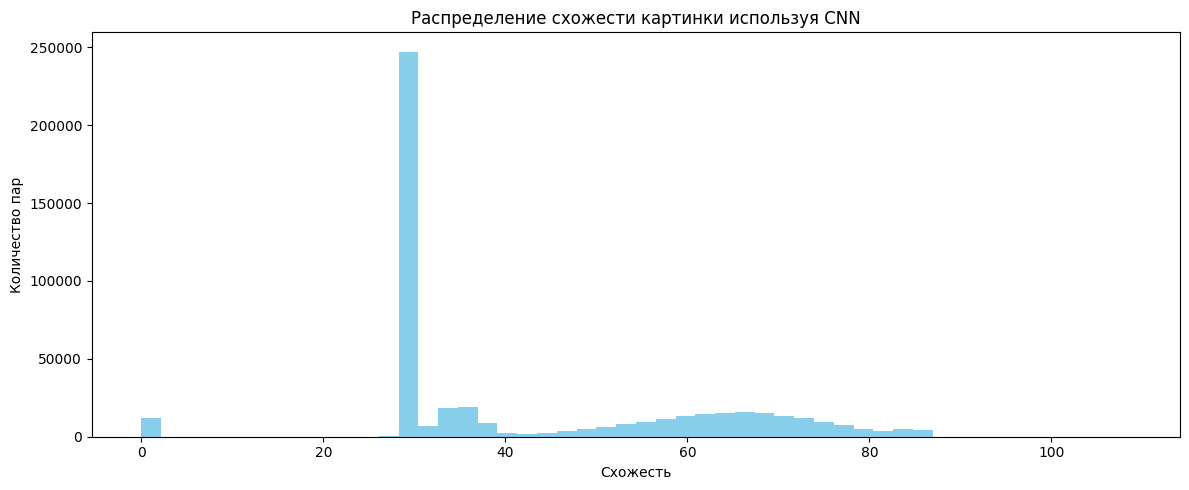

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 5))
plt.hist(df['image_similarity'], bins=50, color='skyblue')
plt.title('Распределение схожести картинки используя CNN')
plt.xlabel('Схожесть')
plt.ylabel('Количество пар')
plt.tight_layout()
plt.show()

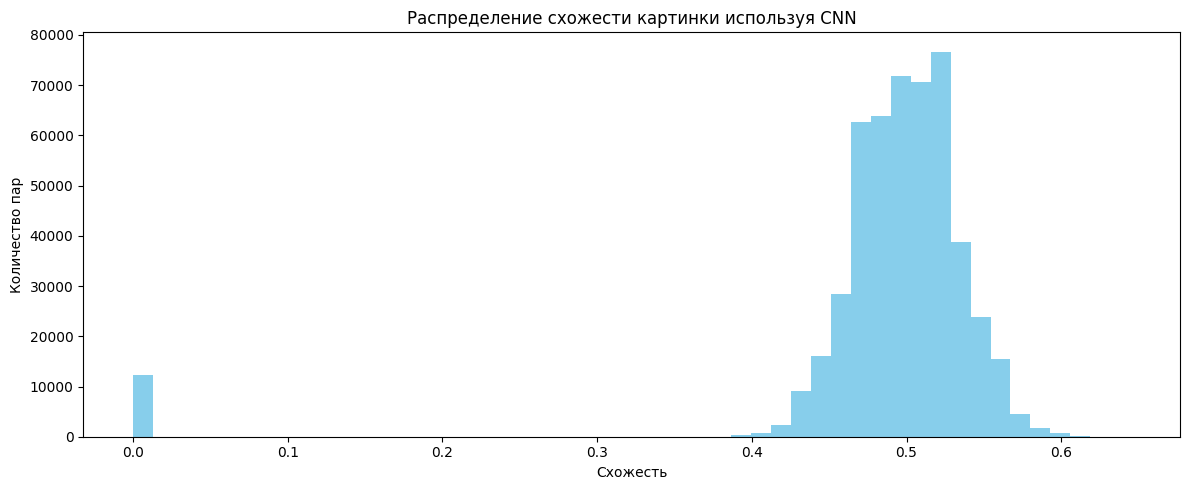

In [16]:
plt.figure(figsize=(12, 5))
plt.hist(df['basic_image_similarity'], bins=50, color='skyblue')
plt.title('Распределение схожести картинки используя CNN')
plt.xlabel('Схожесть')
plt.ylabel('Количество пар')
plt.tight_layout()
plt.show()